In [1]:
import pyPRISMClimate
import rioxarray as rxr
import xarray as xr
import contextily as ctx
import os
import glob
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from concurrent.futures import ThreadPoolExecutor
import pathlib  # Python >= 3.4

In [2]:
def clean_up_files(files:list) -> None:
    [pathlib.Path(f).unlink(missing_ok=True) for f in files]

In [3]:
dates = pd.date_range('2017-02-01', '2017-02-08', freq='1d', inclusive='right', normalize=True)

variables = ['tmean', 'tmax', 'tmin', 'ppt', 'vpdmax', 'vpdmin']
with ThreadPoolExecutor(4) as executor:
    executor.map(
        lambda var: pyPRISMClimate.get_prism_dailys(
            var,
            min_date=dates[0].strftime("%Y-%m-%d"),
            max_date=dates[-1].strftime("%Y-%m-%d"),
            dest_path='../data/weather_data/',
            keep_zip=False
        ),
        variables
    )



In [ ]:
mask = gpd.read_file('../data/GIS/SkagitBoundary.json')
dest_path = "../data/weather_data/"

def create_dataset(min_date, max_date, dest_path, boundaries_gdf):
    if dest_path[-1] == '/':
        dest_path = dest_path[:-1]
        
    output_file = "%s/%s_%s_PRISM_data.zarr" % (dest_path, min_date, max_date)
    rasters = []
    l = pyPRISMClimate.utils.prism_iterator('../data/weather_data/')
    for f in l:
       # open weather file and clip to watershed boundaries
        raster = rxr.open_rasterio(f['full_path'], masked=True)
        raster = raster.rio.clip(boundaries_gdf.to_crs(raster.rio.crs).geometry)
    
        # get date from filename and add as a time coordinate
        date = dt.strptime(f['date'], "%Y-%m-%d")
        raster = raster.expand_dims(dim='time')
        raster.coords['time'] = ('time',[date])
        raster = raster.drop_vars(['spatial_ref']).sel(band=1).drop_vars(['band']).rename(f['variable']).rename({'x':'lon', 'y':'lat'})
        raster.drop_attrs()
    
        #add timestamp to list
        rasters.append(raster)
        
    weather_dataset = xr.merge(rasters)
    weather_dataset.to_zarr(output_file, mode='a')
    
    return weather_dataset

ds = create_dataset(
            min_date='2017-02-01',
            max_date='2017-02-08',
            dest_path='../data/weather_data/',
            boundaries_gdf=mask
)

weather_files = [f['full_path'] for f in pyPRISMClimate.utils.prism_iterator('../data/weather_data/')]
meta_data_files =  glob.glob(os.path.join(dest_path, 'PRISM_*_bil.*'))
clean_up_files(weather_files)
clean_up_files(meta_data_files)
ds

<xarray.Dataset> Size: 217kB
Dimensions:  (lon: 39, lat: 33, time: 7)
Coordinates:
  * lon      (lon) float64 312B -122.3 -122.2 -122.2 ... -120.8 -120.7 -120.7
  * lat      (lat) float64 264B 49.29 49.25 49.21 49.17 ... 48.04 48.0 47.96
  * time     (time) datetime64[ns] 56B 2017-02-02 2017-02-03 ... 2017-02-08
Data variables:
    tmin     (time, lat, lon) float32 36kB nan nan nan nan ... nan nan nan nan
    vpdmin   (time, lat, lon) float32 36kB nan nan nan nan ... nan nan nan nan
    ppt      (time, lat, lon) float32 36kB nan nan nan nan ... nan nan nan nan
    vpdmax   (time, lat, lon) float32 36kB nan nan nan nan ... nan nan nan nan
    tmax     (time, lat, lon) float32 36kB nan nan nan nan ... nan nan nan nan
    tmean    (time, lat, lon) float32 36kB nan nan nan nan ... nan nan nan nan
Attributes:
    STATISTICS_MAXIMUM:  19.809999465942
    STATISTICS_MEAN:     -5.1496808805207
    STATISTICS_MINIMUM:  -29.231000900269
    STATISTICS_STDDEV:   9.0226175283889
    scale_factor:        1.0
    add_offset:          0.0

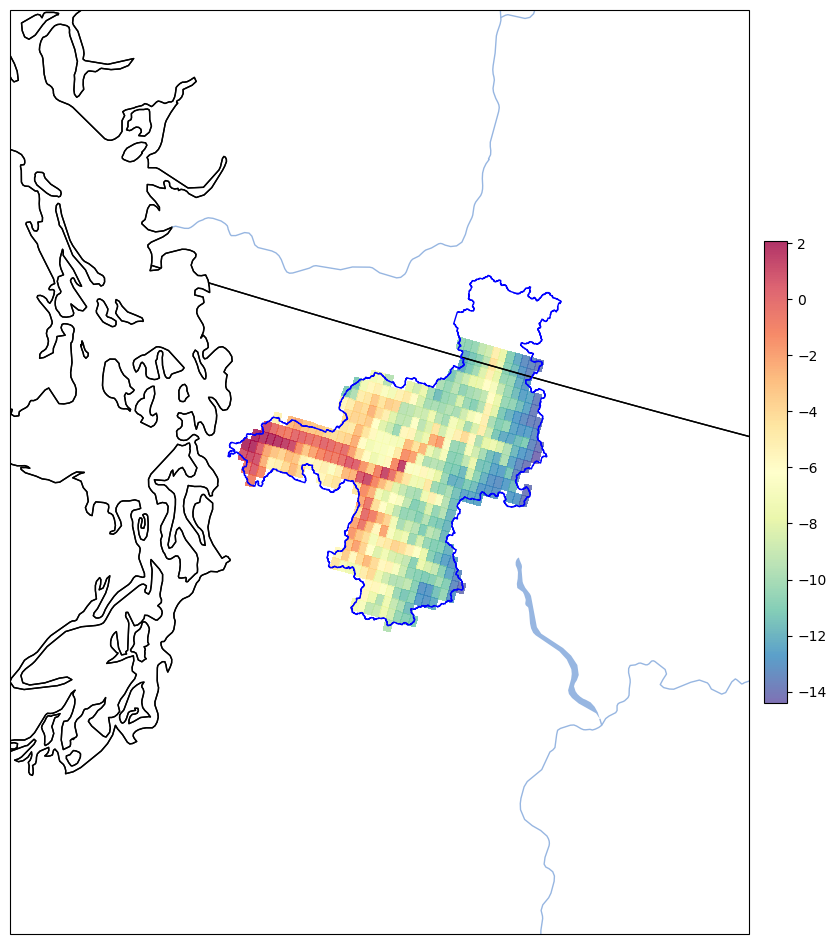

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

projection = ccrs.LambertConformal()
lons = ds.lon
lats = ds.lat
fig = plt.figure(figsize=[20, 12])
ax = plt.axes(projection=projection)
mesh = ax.pcolormesh(lons, lats, ds.tmean.sel(time='2017-02-02'), transform=ccrs.PlateCarree(), cmap='Spectral_r', alpha=.8)
fig.colorbar(mesh, ax=ax, shrink=.5, pad=.01)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.RIVERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.set_extent([-120, -123, 47, 50], crs=ccrs.PlateCarree())
ax.add_geometries([mask.geometry[0]], ccrs.PlateCarree(), edgecolor='blue', facecolor='None')